In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import os
import re

# Data generator class
class ImageDataGeneratorWithLabels(tf.keras.utils.Sequence):
    def __init__(self, gray_folder_path, color_folder_path, batch_size=24, img_size=(256, 256)):
        self.gray_folder_path = gray_folder_path
        self.color_folder_path = color_folder_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.gray_images = os.listdir(gray_folder_path)
        self.color_images = os.listdir(color_folder_path)

        # Augmentation for data
        self.augmentation = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.floor(len(self.gray_images) / self.batch_size))

    def __getitem__(self, index):
        batch_gray = self.gray_images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_color = self.color_images[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        Y_batch = []

        for gray_img, color_img in zip(batch_gray, batch_color):
            gray_path = os.path.join(self.gray_folder_path, gray_img)
            color_path = os.path.join(self.color_folder_path, color_img)

            # Load and preprocess grayscale image
            img_gray = load_img(gray_path, target_size=self.img_size)
            img_gray = img_to_array(img_gray) / 255
            X_batch.append(np.stack((img_gray[:, :, 0],) * 3, axis=-1))  # Convert grayscale to RGB

            # Load and preprocess color image
            img_color = load_img(color_path, target_size=self.img_size)
            img_color = img_to_array(img_color) / 255
            lab_image = rgb2lab(img_color)
            lab_image_norm = (lab_image + [0, 128, 128]) / [100, 255, 255]
            Y_batch.append(lab_image_norm[:, :, 1:])  # Keep only AB channels

        # Apply augmentation
        X_batch = np.array(X_batch, dtype=np.float32)
        Y_batch = np.array(Y_batch, dtype=np.float32)

        # Using the ImageDataGenerator for augmentation
        augmented_X_batch = self.augmentation.flow(X_batch, batch_size=self.batch_size, shuffle=False).__next__()

        return augmented_X_batch, Y_batch


# Paths to folders containing images
gray_folder_path = './Images/gray/'
color_folder_path = './Images/color/'

# Initialize data generators for training and validation
train_data_gen = ImageDataGeneratorWithLabels(gray_folder_path, color_folder_path, batch_size=24)
val_data_gen = ImageDataGeneratorWithLabels(gray_folder_path, color_folder_path, batch_size=24)  # Replace with actual validation paths

# Function to get latest epoch from checkpoint files
def get_latest_epoch(checkpoint_dir):
    files = os.listdir(checkpoint_dir)
    epoch_files = [f for f in files if re.search(r'model_epoch_(\d+).keras', f)]
    if not epoch_files:
        return None, None
    latest_file = max(epoch_files, key=lambda f: int(re.search(r'(\d+)', f).group()))
    latest_epoch = int(re.search(r'(\d+)', latest_file).group())
    return latest_file, latest_epoch

# Load VGG16 model without fully connected layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze VGG16 layers
for layer in vgg.layers:
    layer.trainable = False

# Build the model
x = vgg.output
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Output: (16, 16, 512)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Output: (32, 32, 256)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Output: (64, 64, 128)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Output: (128, 128, 64)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Output: (256, 256, 32)

# Final output layer with 2 channels (AB)
output_layer = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)  # (256, 256, 2)

# Create the final model
model = Model(inputs=vgg.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mse')

# Check for existing checkpoints and load the latest one
checkpoint_dir = './colorizationCheckpoints/'
latest_file, latest_epoch = get_latest_epoch(checkpoint_dir)

if latest_file:
    print(f"Loading model from checkpoint: {latest_file}")
    model.load_weights(os.path.join(checkpoint_dir, latest_file))
else:
    print("No checkpoints found, starting training from scratch.")
    latest_epoch = 0

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define checkpoint callback to save the model at each epoch
checkpoint_filepath = './colorizationCheckpoints/model_epoch_{epoch:02d}.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_best_only=False,  # Set to True to only save the best model based on val_loss
    save_weights_only=False,  # Save the entire model, not just the weights
    monitor='val_loss',  # Monitor validation loss
    verbose=1  # Display message when saving model
)

# Train the model and save checkpoints
model.fit(
    train_data_gen,
    epochs=latest_epoch + 100,  # Continue training from latest epoch
    initial_epoch=latest_epoch,
    callbacks=[early_stopping, model_checkpoint],  # Add model checkpoint to callbacks
    validation_data=val_data_gen  # You should replace this with a separate validation generator
)

Loading model from checkpoint: model_epoch_06.keras


c:\python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 7/106


c:\python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


287/323 ━━━━━━━━━━━━━━━━━━━━ 16:22 27s/step - loss: 0.0024

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


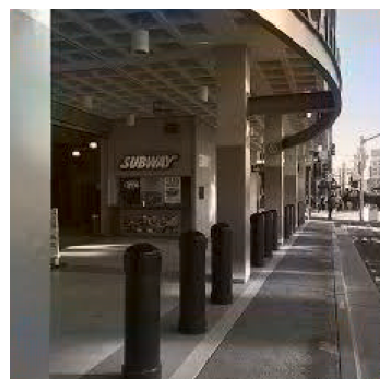

In [1]:
import numpy as np
import os
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
from keras.models import load_model
from skimage.transform import resize  # Import resize for better quality

# Load your trained model
model = load_model('./colorizationCheckpoints/model_epoch_06.keras')  # Adjust the path and file name as necessary

# Testing the model with a higher resolution image
folder_path = './Images/gray/'
img_name = 'image_605.jpg'
img_path = os.path.join(folder_path, img_name)

# Load and preprocess grayscale image with the required resolution
img = load_img(img_path, target_size=(256, 256), color_mode="grayscale")  # Change target size to 256x256
img = img_to_array(img) / 255.0  # Scale to [0, 1]

# Convert grayscale image to a 3-channel image by repeating the single channel
img_rgb = np.stack((img[:, :, 0],) * 3, axis=-1)  # Create RGB image from grayscale
X_test = np.expand_dims(img_rgb, axis=0)  # Add batch dimension, resulting in shape (1, 256, 256, 3)

# Predict and reshape the output
output = model.predict(X_test)
output = np.reshape(output, (256, 256, 2))  # Resize to (256, 256, 2)

# Create the LAB image with the correct scaling
outputLAB = np.zeros((256, 256, 3))
outputLAB[:, :, 0] = img[:, :, 0] * 100  # L channel, scaled to [0, 100]
outputLAB[:, :, 1:] = output * 255 - 128  # AB channels, scaled to [-128, 127]

# Convert LAB image back to RGB
rgb_image = lab2rgb(outputLAB)

# Resize the final RGB image to 256x256 for better quality display
rgb_image_resized = resize(rgb_image, (256, 256), anti_aliasing=True)

# Show the output image
plt.imshow(rgb_image_resized)
plt.axis('off')
plt.show()
